# Tensile Strength Ratio

In [20]:
#%% IMPORTS
#BASICS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import absolute
from pandas.plotting import scatter_matrix
from sklearn.pipeline import make_pipeline
from IPython.display import display, Markdown, Latex
pd.options.display.max_columns = None

#STATISTICS
from scipy.stats import normaltest
from scipy import stats

#ML TRAINING AND DATA PREPROCESSING
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures

#ML MODELS
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor
import xgboost as xgb
from xgboost import plot_importance

#MODEL EVALUATION
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold

#METRICS
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

## 1. Methods

In [21]:
#Eliminate Outliers based on the interquantile
#datFrame: Data frame where the outliers will be eliminated.
#columnName: the name of the column where the outliers will be identified.
def eliminateOutliers (dataFrame, columnName):
    Q1 = dataFrame[columnName].quantile(0.25)
    Q3 = dataFrame[columnName].quantile(0.75)
    IQR = Q3 - Q1
    print('Initial dataframe size: '+str(dataFrame.shape))
    dataFrame = dataFrame[(dataFrame[columnName] < (Q3 + 1.5 * IQR)) & (dataFrame[columnName] > (Q1 - 1.5 * IQR))]
    print('Final dataframe size: '+str(dataFrame.shape))
    return dataFrame

In [22]:
# Create the boxplot graphs for the categorical variables
# dataFrame: Data frame associated to the property of interest (dfAirVoids, dfMS, dfMF, dfITS, dfTSR)
# propertyOfInterest: the name of the column where the property of interest is located.
# columnName1...4: The categorical columns to evaluate.
def displayBoxPlotGraphs (dataFrame, propertyOfInterest, columnName1, columnName2, columnName3, columnName4):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15,10))
    sns.boxplot(y = propertyOfInterest, x = columnName1, data=dataFrame,  orient='v' , ax=ax1)
    sns.boxplot(y = propertyOfInterest, x = columnName2, data=dataFrame,  orient='v' , ax=ax2)
    sns.boxplot(y = propertyOfInterest, x= columnName3, data=dataFrame,  orient='v' , ax=ax3)
    sns.boxplot(y= propertyOfInterest, x= columnName4, data=dataFrame,  orient='v' , ax=ax4)

In [23]:
#Method that print the best parameters, R2 and MSE based on a grid search.
def printBestModel (grid):
    mse = grid.best_score_
    print('Best Parameters:' , grid.best_params_)
    print('Best MSE:' + str(-mse))

## 2. Data Import

In [24]:
#%%DATA READING AND INITIAL PREPROCESSING
numericColumns = ['Aggregate absorption (%)',
                  'Apparent specific gravity',
                    0.075,
                    0.3,
                    0.6,
                    2.36,
                    4.75,
                    9.5,
                    12.5,
                    19,
                    'Plastic particle size (mm)',
                    'Mixing speed (RPM)',
                    'Mixing Temperature',
                    'Mixing Time (hours)',
                    'Plastic Addition by bitumen weight (%)',
                    'Bitumen content in the sample'
                    ]
categoricalColumns = ['Modified asphalt Mix?',
                      'Agreggate Type',
                    'Aggregate absorption (%)',
                    'Filler used',
                    'Consolidated bitumen penetration grade',
                    'New Plastic Type',
                    'Plastic pretreatment',
                    'Plastic shape',
                    'Plastic Size',
                    'Mixing Process',
                    'Plastic melted previous to addition?',
                    'Aggregates replacement ?',
                    'Bitumen replacement?',
                    'Filler replacement',
                    'Property',
                    'Units']
#It returns the dataframe of interes based on the property - 'AirVoids', 'MS', 'MF', 'ITS', 'TSR'
def returnDf (propertyOfInterest):
    df = pd.read_excel('fileML.xlsx', sheet_name = propertyOfInterest, engine='openpyxl')
    df = df.set_index(propertyOfInterest + ' ID')
    df.loc[:,:'Units'] = df.loc[:,:'Units'].applymap(str)
    df.loc[:,:'Units'] = df.loc[:,:'Units'] .applymap(str.strip)
    df.replace('NS', np.nan, inplace = True)
    df[numericColumns] = df[numericColumns].replace('N/a', 0).astype(float)
    return df

In [25]:
dfTSR = returnDf('TSR')

## 3. Data Exploration
###  3.1 Total Sample

In [26]:
dfTSR = eliminateOutliers(dfTSR, 'TSR of the sample[%]')

Initial dataframe size: (147, 34)
Final dataframe size: (146, 34)


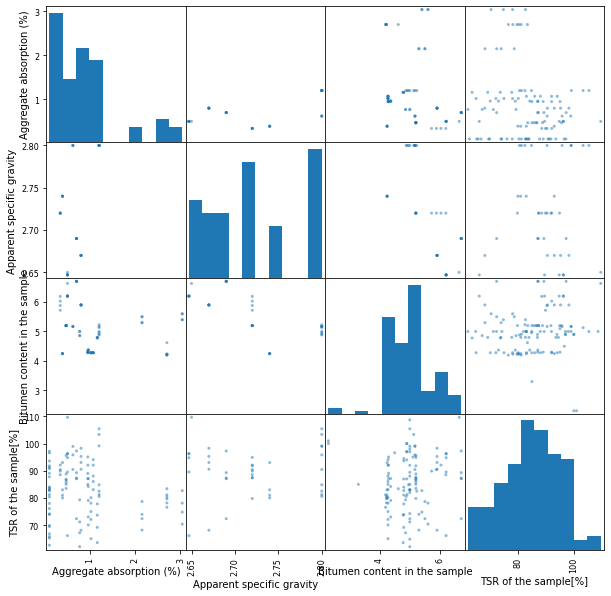

In [27]:
scatter_matrix(dfTSR[['Aggregate absorption (%)', 'Apparent specific gravity', 'Bitumen content in the sample', 'TSR of the sample[%]']], figsize=(10, 10))
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap TSR')

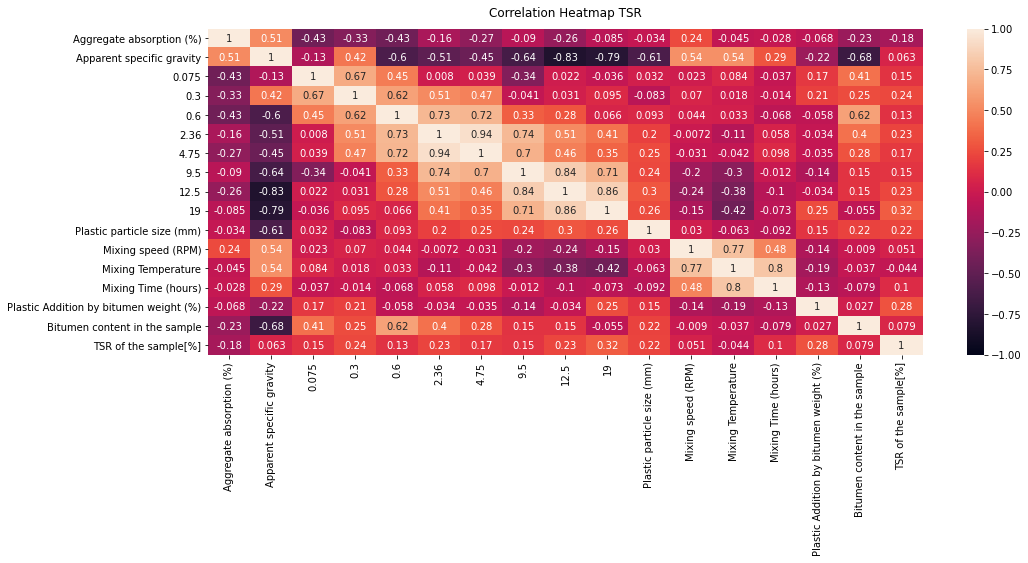

In [28]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfTSR.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap TSR', fontdict={'fontsize':12}, pad=12)

Positive correlation with $\color{red}{\text{gradiation}}$ and negative with $\color{red}{\text{Aggregate absorption}}$.

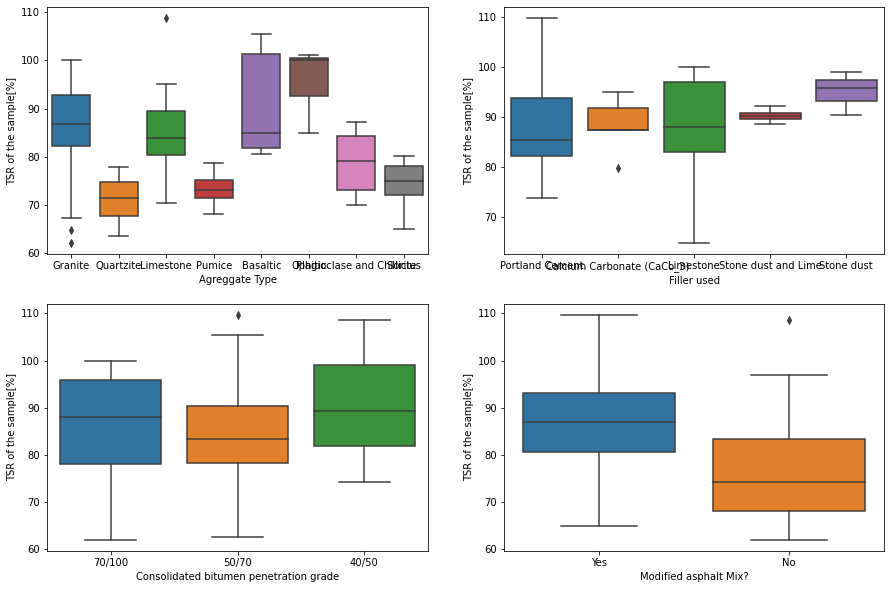

In [29]:
displayBoxPlotGraphs(dataFrame = dfTSR, propertyOfInterest = 'TSR of the sample[%]', columnName1 = "Agreggate Type", columnName2 = "Filler used", columnName3 = "Consolidated bitumen penetration grade", columnName4 = "Modified asphalt Mix?")

It exists an strong difference between modified and unmodified asphalt mixture.

###  3.2 Modified mixtures

In [30]:
dfTSRModvsUnmod = dfTSR [['Modified asphalt Mix?', 'TSR of the sample[%]']]
dfTSRModvsUnmod.groupby(['Modified asphalt Mix?'], as_index=False).describe()

TSR of the sample[%]                                                    \
                 count       mean        std    min    25%    50%    75%   
0                 29.0  77.650690  12.040712  62.10  68.20  74.27  83.40   
1                117.0  86.481966   9.081616  64.88  80.54  87.06  93.03   

           
      max  
0  108.68  
1  109.65

In [31]:
dfTSRModified = dfTSR[dfTSR['Modified asphalt Mix?'] == 'Yes']
dfTSRModified.iloc[:,2:].describe(include = "all")

Modified asphalt Mix? Agreggate Type  Aggregate absorption (%)  \
count                    117             72                 87.000000   
unique                     1              8                       NaN   
top                      Yes        Granite                       NaN   
freq                     117             31                       NaN   
mean                     NaN            NaN                  0.762644   
std                      NaN            NaN                  0.717300   
min                      NaN            NaN                  0.100000   
25%                      NaN            NaN                  0.100000   
50%                      NaN            NaN                  0.620000   
75%                      NaN            NaN                  1.020000   
max                      NaN            NaN                  3.040000   

        Apparent specific gravity       0.075         0.3         0.6  \
count                   33.000000  112.000000  112.000000  115.000000   
unique                        NaN         NaN         NaN         NaN   
top                           NaN         NaN         NaN         NaN   
freq                          NaN         NaN         NaN         NaN   
mean                     2.722970    5.670625   13.064464   22.508957   
std                      0.055432    1.611836    3.705004    8.060013   
min                      2.647000    2.860000    7.030000   10.070000   
25%                      2.670000    4.800000   11.930000   14.830000   
50%                      2.720000    5.980000   13.250000   21.250000   
75%                      2.800000    7.000000   14.000000   28.000000   
max                      2.800000    9.700000   23.000000   39.160000   

              2.36        4.75         9.5        12.5          19  \
count   115.000000  115.000000  115.000000  115.000000  115.000000   
unique         NaN         NaN         NaN         NaN         NaN   
top            NaN         NaN         NaN         NaN         NaN   
freq           NaN         NaN         NaN         NaN         NaN   
mean     36.762435   51.686174   72.957478   85.715043   95.414783   
std       8.090863    9.951942   10.827463    9.761514    6.150659   
min      19.770000   23.950000   47.000000   66.630000   83.110000   
25%      31.865000   44.780000   65.000000   80.000000   89.000000   
50%      34.520000   52.000000   69.970000   81.420000   99.870000   
75%      38.800000   54.830000   79.950000   94.910000  100.000000   
max      54.100000   71.080000   96.870000  100.000000  100.020000   

       Filler used Bitumen Type Penetration Grade  \
count           34                            117   
unique           5                              6   
top      Limestone                          60/70   
freq            16                             55   
mean           NaN                            NaN   
std            NaN                            NaN   
min            NaN                            NaN   
25%            NaN                            NaN   
50%            NaN                            NaN   
75%            NaN                            NaN   
max            NaN                            NaN   

       Consolidated bitumen penetration grade New Plastic Type  \
count                                     117              117   
unique                                      3                5   
top                                     50/70               PE   
freq                                       77               69   
mean                                      NaN              NaN   
std                                       NaN              NaN   
min                                       NaN              NaN   
25%                                       NaN              NaN   
50%                                       NaN              NaN   
75%                                       NaN              NaN   
max                                       NaN    

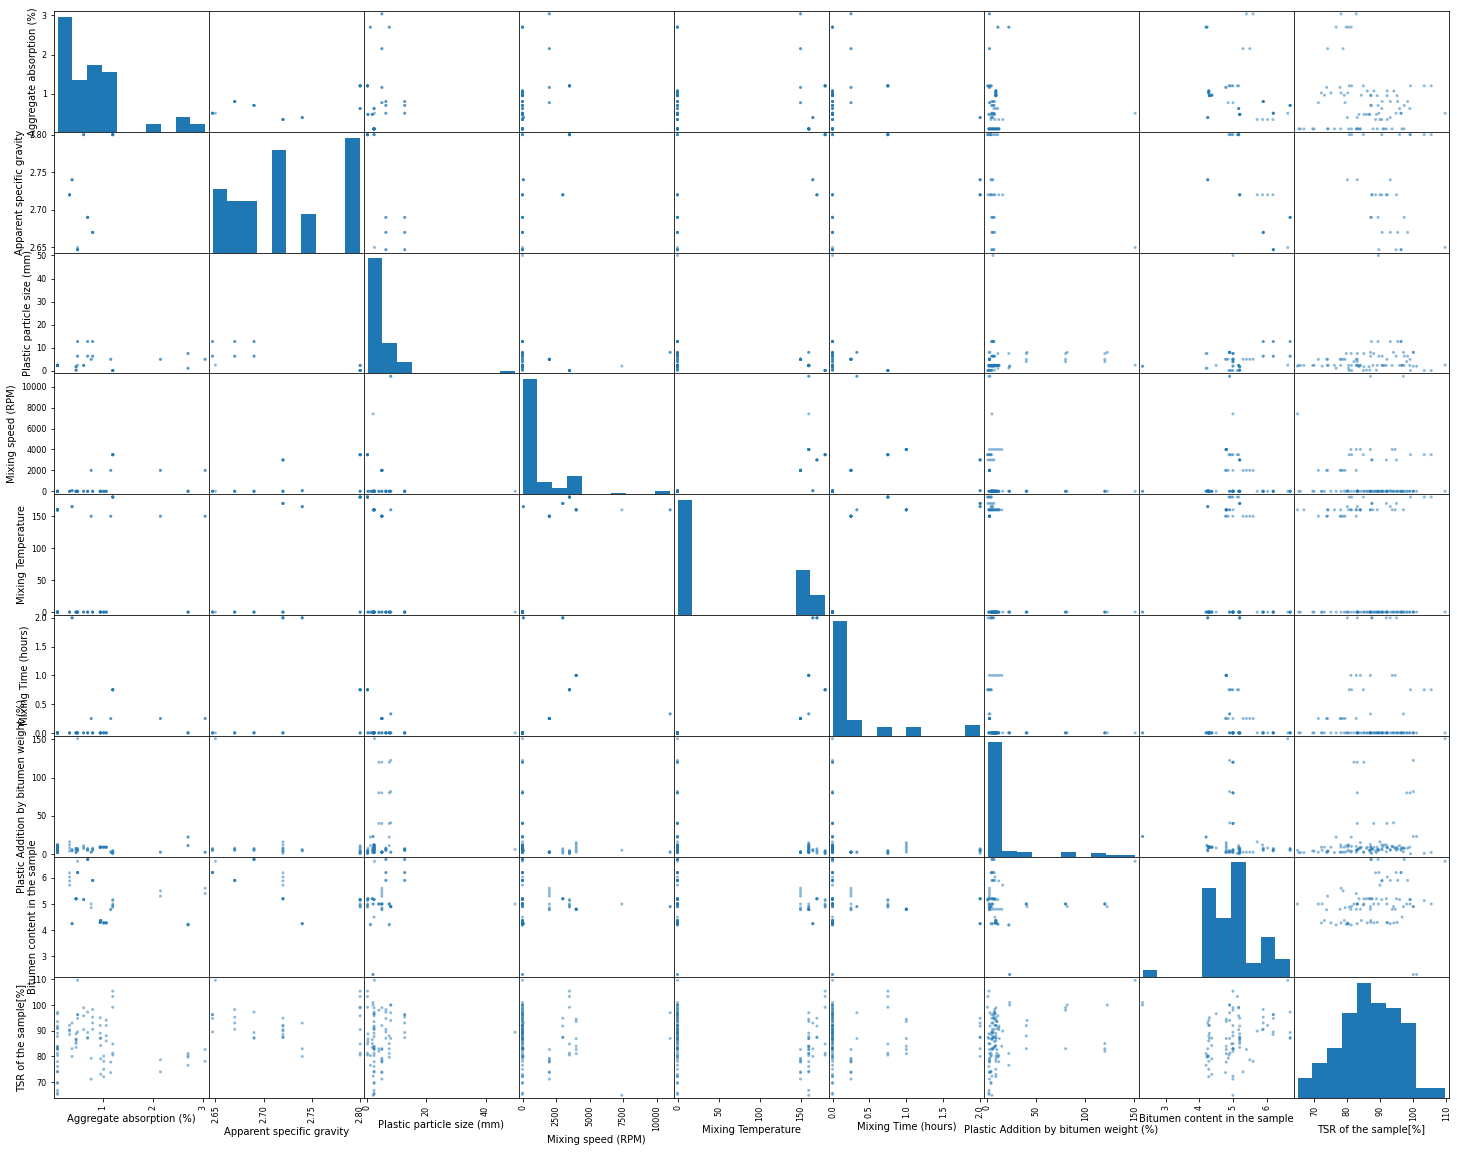

In [32]:
columnsOfInteres = numericColumns[0:2]+numericColumns[10:]+['TSR of the sample[%]']
scatter_matrix(dfTSRModified[columnsOfInteres], figsize=(25, 20))
plt.show()

Text(0.5, 1.0, 'Correlation Heatmap TSR')

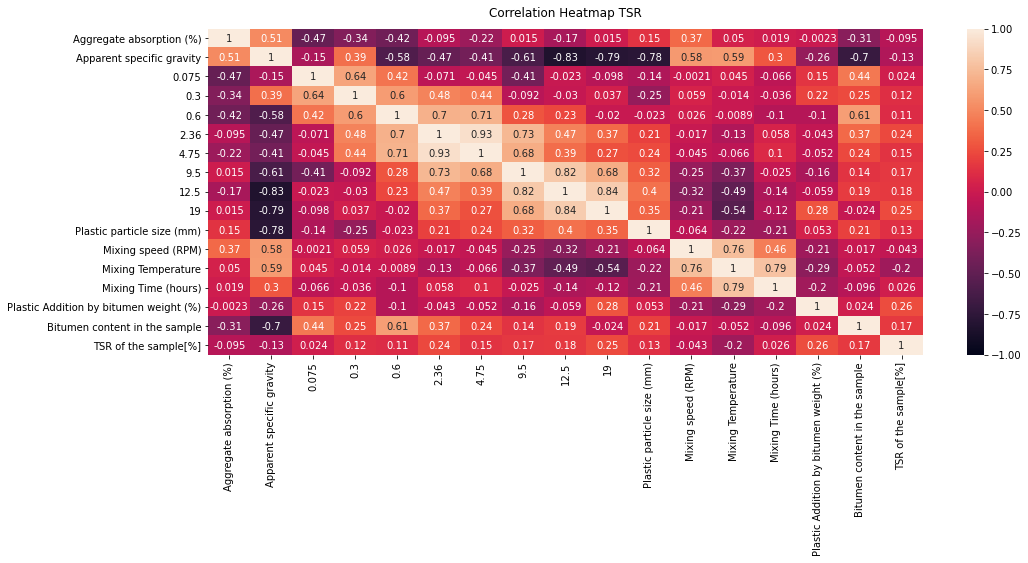

In [33]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(dfTSRModified.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap TSR', fontdict={'fontsize':12}, pad=12)

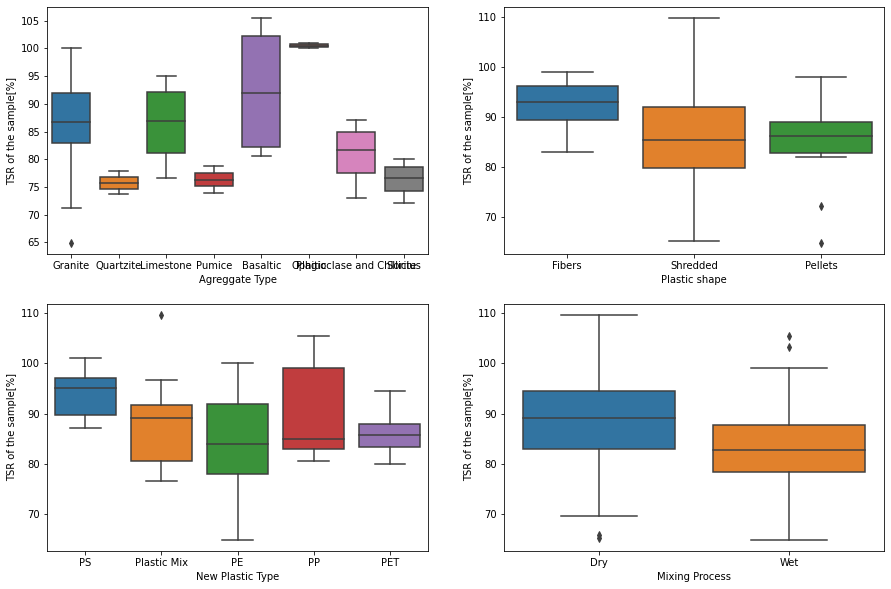

In [34]:
displayBoxPlotGraphs(dataFrame = dfTSRModified, propertyOfInterest = "TSR of the sample[%]", columnName1 = "Agreggate Type", columnName2 = "Plastic shape", columnName3 = "New Plastic Type", columnName4 = "Mixing Process")

The large correlation is with $\color{red}{\text{plastic addition quantity}}$, and it exists a significant difference between $\color{red}{\text{wet}}$ and $\color{red}{\text{dry}}$ mixing.

### 3.3 Wet vs. Dry Mixing

In [35]:
dfTSRWetvsDry = dfTSRModified [['Mixing Process', 'TSR of the sample[%]']]
dfTSRWetvsDry.groupby(['Mixing Process'], as_index=False).describe()

TSR of the sample[%]                                                      \
                 count       mean       std    min    25%     50%      75%   
0                 75.0  88.016400  8.838495  65.24  83.00  89.040  94.4350   
1                 42.0  83.741905  8.963967  64.88  78.25  82.705  87.6825   

           
      max  
0  109.65  
1  105.42

C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


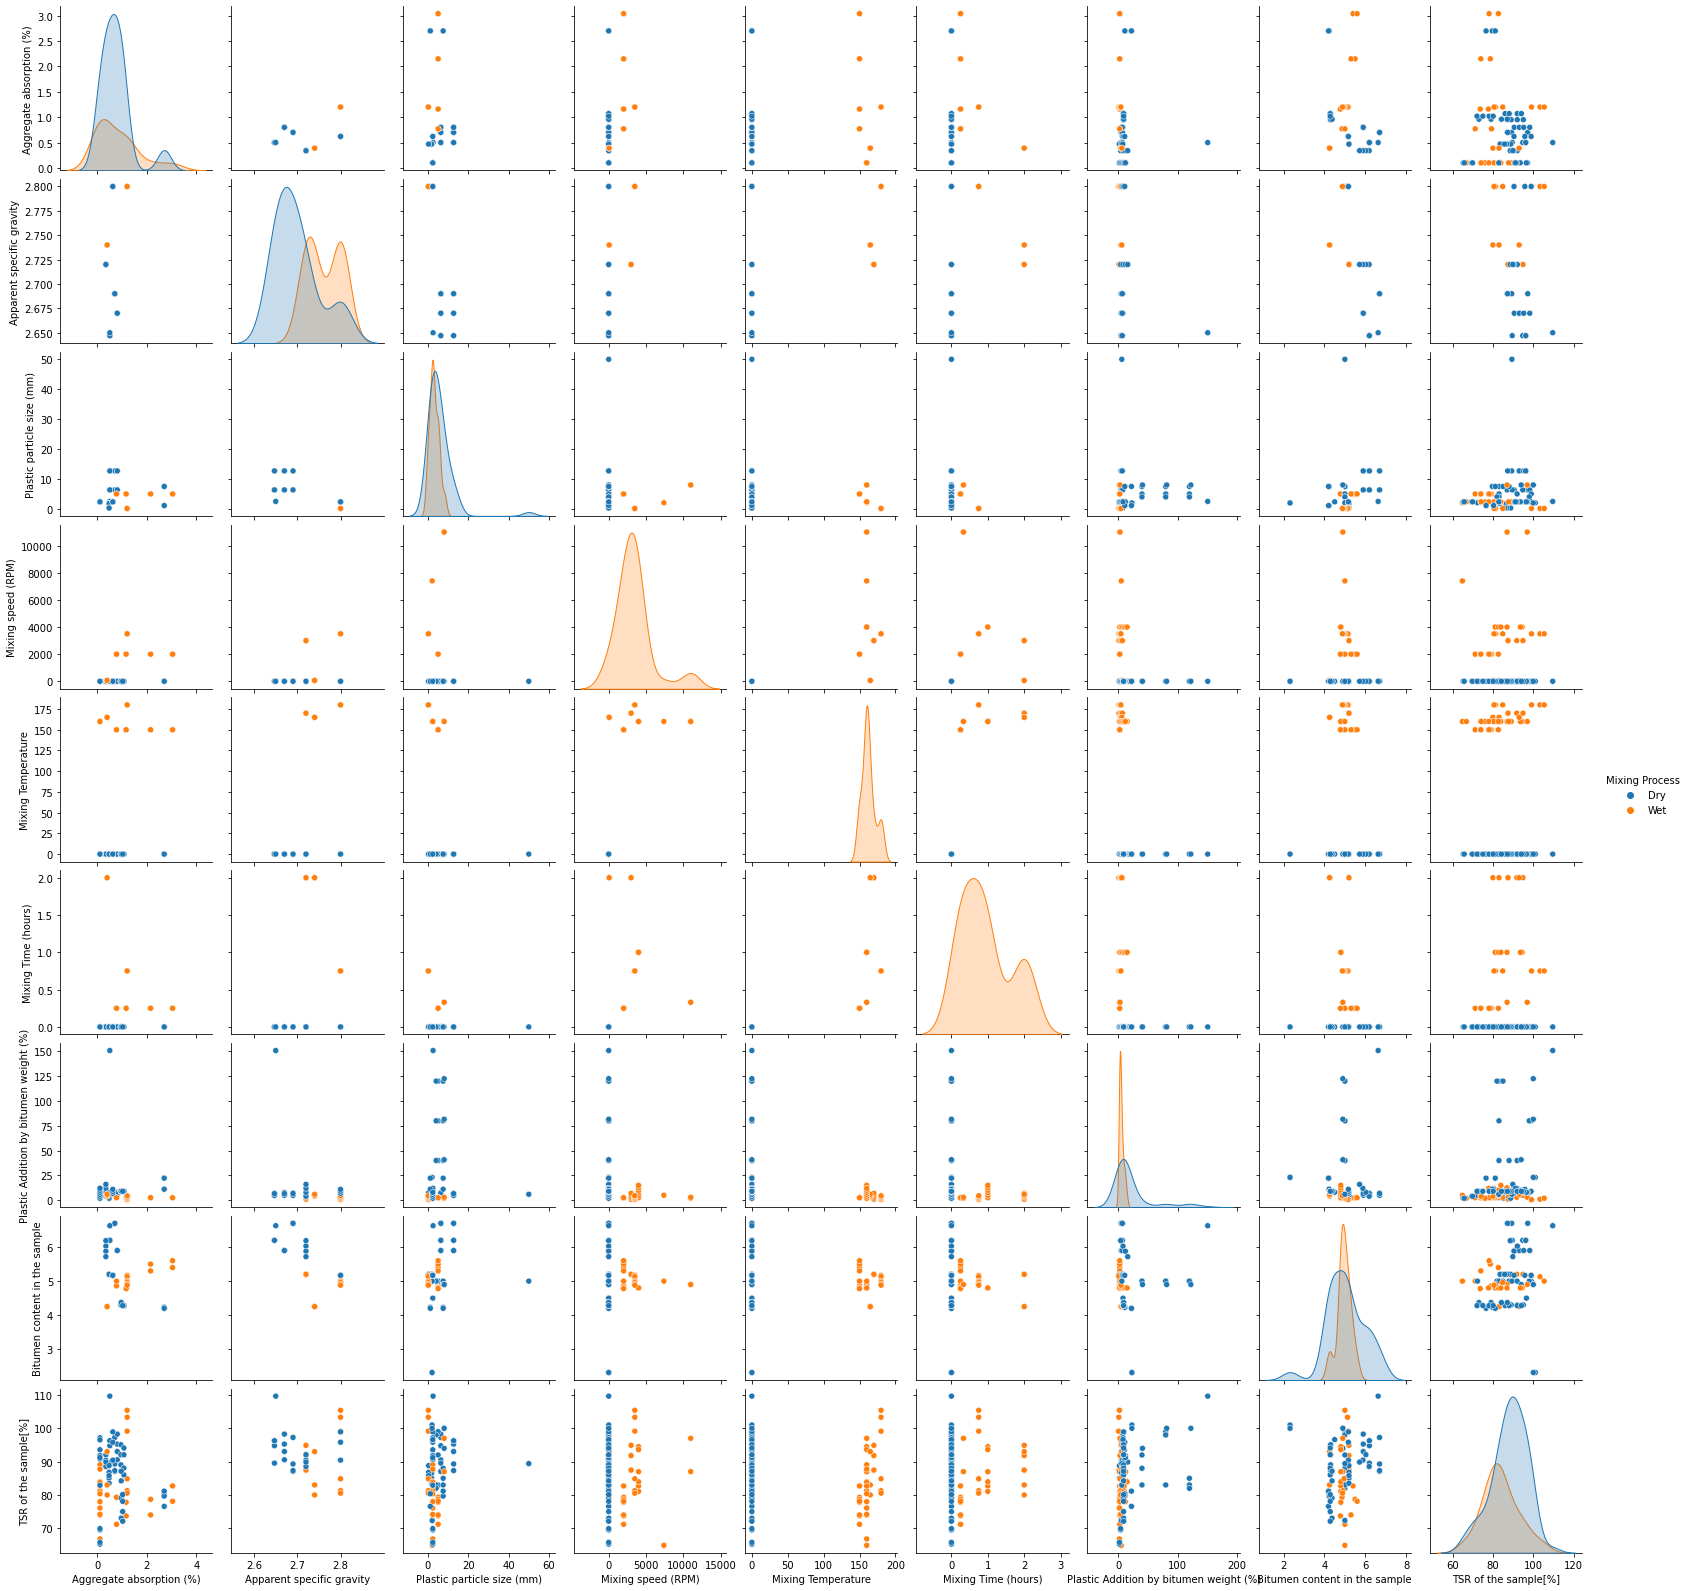

In [36]:
sns.pairplot(dfTSRModified[columnsOfInteres+['Mixing Process']], hue="Mixing Process", height=2.5)

##  **TSR summary:**

 *  1 outliers were eliminated from the original sample.
 *  Total number of observation: 146 -> $\mu$ = 84, $\sigma$ = 10.31.
 *  Highest positive correlation with $\color{red}{\text{gradation}}$, and it exists a negative correlation with $\color{red}{\text{aggregate absorptionn}}$ (r = -0.18)
 *  Some difference between the modified and unmodified mixtures -> $\mu_{modified}$ = 86.48,  $\mu_{unmodified}$ = 77.65.
 *  Modified mixtures present positive correlation with $\color{red}{\text{plastic addition}}$ (r = 0.26).
 *  Possible difference between dry and wet.  Dry ($\mu_{dry}$ = 88, $\sigma_{dry}$ = 8.9) vs. wet ($\mu_{wet}$ = 83.7, $\sigma_{wet}$ = 8.3) -> This is not conclusive because the variance of both sample groups is large.

## 4. Data Pre-processing

In [37]:
dfTSR.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 1 to 147
Data columns (total 34 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Article ID                              146 non-null    object 
 1   Global ID                               146 non-null    object 
 2   Modified asphalt Mix?                   146 non-null    object 
 3   Agreggate Type                          95 non-null     object 
 4   Aggregate absorption (%)                108 non-null    float64
 5   Apparent specific gravity               39 non-null     float64
 6   0.075                                   139 non-null    float64
 7   0.3                                     139 non-null    float64
 8   0.6                                     143 non-null    float64
 9   2.36                                    143 non-null    float64
 10  4.75                                    143 non-null    float6

###  Pre-processing:
1.  Eliminate the columns $\color{red}{\text{Article ID}}$, $\color{red}{\text{Global ID}}$, $\color{red}{\text{Aggregate type}}$, $\color{red}{\text{Apparent specific gravity}}$, $\color{red}{\text{filler used}}$, $\color{red}{\text{Bitumen type penetration grade}}$, $\color{red}{\text{plastic size}}$, $\color{red}{\text{Property}}$ and $\color{red}{\text{Units}}$.
2.  Change the N/a to zero. This is for the unmodified mixtures.
4.  Change categorical columns to numeric - $\color{red}{\text{Modified asphalt Mix?}}$, $\color{red}{\text{Consolidated bitumen penetration grade}}$, $\color{red}{\text{New Plastic Type}}$, $\color{red}{\text{Plastic pretreatment}}$, $\color{red}{\text{Plastic shape}}$, $\color{red}{\text{Mixing Process}}$, $\color{red}{\text{Plastic melted previous to addition?}}$, $\color{red}{\text{Replacements}}$.
5.  Imputer to $\color{red}{\text{Aggregate absorption}}$, $\color{red}{\text{gradations}}$, $\color{red}{\text{plastic size(mm)}}$, $\color{red}{\text{mixing parameters}}$ and $\color{red}{\text{Bitumen content in the sample}}$.

In [38]:
dfTSRCleaned = dfTSR.drop(['Article ID', 
                        'Global ID',
                        'Modified asphalt Mix?',
                        'Agreggate Type', 
                        'Apparent specific gravity', 
                        'Filler used', 
                        'Bitumen Type Penetration Grade',
                        'Plastic Size', 
                        'Property', 
                        'Units'], axis = 1)
dfTSRCleaned = dfTSRCleaned.replace('N/a', 0)
dfTSRCleaned = pd.get_dummies(dfTSRCleaned, columns=['New Plastic Type'], drop_first = False)
dfTSRCleaned = pd.get_dummies(dfTSRCleaned, drop_first=True)
dfTSRCleaned = dfTSRCleaned.drop(['New Plastic Type_0'], axis = 1)
dfTSRCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 1 to 147
Data columns (total 32 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       108 non-null    float64
 1   0.075                                          139 non-null    float64
 2   0.3                                            139 non-null    float64
 3   0.6                                            143 non-null    float64
 4   2.36                                           143 non-null    float64
 5   4.75                                           143 non-null    float64
 6   9.5                                            143 non-null    float64
 7   12.5                                           143 non-null    float64
 8   19                                             143 non-null    float64
 9   Plastic particle size (mm)                     113 non

In [39]:
#IMPUTATION OF MISSING VALUES
imputer = IterativeImputer (estimator = ExtraTreesRegressor(n_estimators=10, random_state=0), max_iter=100)
n = imputer.fit_transform(dfTSRCleaned)
dfTSRCleanedImputed = pd.DataFrame(n, columns = list(dfTSRCleaned.columns))
dfTSRCleanedImputed.info()
print ('There is '+str(sum(n < 0 for n in dfTSRCleanedImputed.values.flatten()))+' negative values in the new Dataframe')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 32 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Aggregate absorption (%)                       146 non-null    float64
 1   0.075                                          146 non-null    float64
 2   0.3                                            146 non-null    float64
 3   0.6                                            146 non-null    float64
 4   2.36                                           146 non-null    float64
 5   4.75                                           146 non-null    float64
 6   9.5                                            146 non-null    float64
 7   12.5                                           146 non-null    float64
 8   19                                             146 non-null    float64
 9   Plastic particle size (mm)                     146 non

In [40]:
dfTSRCleanedImputed['New Plastic Type_PE'] = dfTSRCleanedImputed['New Plastic Type_PE'] * dfTSRCleanedImputed['Plastic Addition by bitumen weight (%)']
dfTSRCleanedImputed['New Plastic Type_PET'] = dfTSRCleanedImputed['New Plastic Type_PET'] * dfTSRCleanedImputed['Plastic Addition by bitumen weight (%)']
dfTSRCleanedImputed['New Plastic Type_PP'] = dfTSRCleanedImputed['New Plastic Type_PP'] * dfTSRCleanedImputed['Plastic Addition by bitumen weight (%)']
dfTSRCleanedImputed['New Plastic Type_PS'] = dfTSRCleanedImputed['New Plastic Type_PS'] * dfTSRCleanedImputed['Plastic Addition by bitumen weight (%)']
dfTSRCleanedImputed['New Plastic Type_Plastic Mix'] = dfTSRCleanedImputed['New Plastic Type_Plastic Mix'] * dfTSRCleanedImputed['Plastic Addition by bitumen weight (%)']
dfTSRCleanedImputed = dfTSRCleanedImputed.drop(['Plastic Addition by bitumen weight (%)'], axis = 1)

In [41]:
scaler = MinMaxScaler()
dfTSRCleanedImputedScaled = pd.DataFrame(scaler.fit_transform(dfTSRCleanedImputed), columns = list(dfTSRCleanedImputed.columns))
dfTSRCleanedImputedScaled.to_clipboard()

## 5. Model Training

In [43]:
X = dfTSRCleanedImputedScaled.loc[:, dfTSRCleanedImputedScaled.columns != 'TSR of the sample[%]']
y = dfTSRCleanedImputedScaled.loc[:,'TSR of the sample[%]']
cv = RepeatedKFold(n_splits = 5, n_repeats = 10, random_state = 123)

### 5.1 Model Evaluation
#### Linear Model

In [44]:
param_grid = {'fit_intercept': [True, False],
            'positive': [True, False]}
grid = GridSearchCV(LinearRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'fit_intercept': False, 'positive': True}
Best MSE:0.039610417815713034


#### Lasso Linear Model

In [45]:
param_grid = {'alpha': [0.001,1, 10, 15, 30, 50, 100],
            'fit_intercept':[True, False],
            'positive': [True, False]}
grid = GridSearchCV(Lasso(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'alpha': 0.001, 'fit_intercept': False, 'positive': False}
Best MSE:0.035301358992877216


#### Ridge Linear regression model

In [46]:
param_grid = {'alpha': [0,5,15,100],
'fit_intercept': [True, False],
'solver': [ 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}
grid = GridSearchCV(Ridge(), param_grid, cv=10, scoring=['r2','neg_mean_squared_error'], refit = 'r2')
grid.fit(X, y)
printBestModel(grid)

C:\Users\cavs1\Anaconda3\envs\spyder\lib\site-packages\sklearn\linear_model\_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=1.77627e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,
Best Parameters: {'alpha': 15, 'fit_intercept': True, 'solver': 'lsqr'}
Best MSE:0.15438981065489002


#### Linear Elastic net

In [47]:
param_grid = {'alpha': [0.01,1,2,3,4],
'fit_intercept': [True, False]}
grid = GridSearchCV(ElasticNet(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'alpha': 0.01, 'fit_intercept': True}
Best MSE:0.03946532843289101


#### Polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), LinearRegression(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'linearregression__fit_intercept': [True, False],
'linearregression__positive':[True, False]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

#### Lasso Polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Lasso(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
            'lasso__alpha': [1, 10, 15, 30, 50, 100],
            'lasso__fit_intercept':[True, False],
            'lasso__positive': [True, False],
            'lasso__max_iter': [3000]}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit = 'neg_mean_squared_error', return_train_score= True)
grid.fit(X, y)
printBestModel(grid)

#### Ridge polynomial model

In [ ]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree), Ridge(**kwargs))

param_grid = {'polynomialfeatures__degree': [2,3],
'ridge__alpha':[10, 20,30,50],
'ridge__fit_intercept': [True, False],
'ridge__solver': [ 'lsqr', 'cholesky', 'sparse_cg', 'svd', 'sag']}
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

#### Support vector regression

In [48]:
param_grid = {
    'kernel':['linear','rbf', 'sigmoid','poly'],
    'degree':[2,3],
    'C':[0.01,1,5,10],
    'epsilon':[0.1,0.5, 1, 1.5]
}
grid = GridSearchCV(SVR(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'C': 10, 'degree': 2, 'epsilon': 0.1, 'kernel': 'poly'}
Best MSE:0.03498973248365726


#### Decision Tree regressor

In [49]:
param_grid = {
    'max_depth':[2,3,5,10],
    'min_samples_split':[2,3,4],
    'min_samples_leaf':[1,2]
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error')
grid.fit(X, y)
printBestModel(grid)

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 3}
Best MSE:0.028546565060473705


#### Random Forest

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(RandomForestRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=100)
grid.fit(X, y)
printBestModel(grid)

#### Extra tree regressor

In [ ]:
param_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
grid = RandomizedSearchCV(ExtraTreesRegressor(), param_grid, cv=cv, scoring=['r2','neg_mean_squared_error'], refit='neg_mean_squared_error', n_iter=100)
grid.fit(X, y)
printBestModel(grid)

#### XG Boost Regressor

In [50]:
XGBoostModel = XGBRegressor()
scores = cross_val_score(XGBoostModel, X, y , scoring = 'neg_mean_squared_error', cv = cv)
scores = np.absolute(scores)
print (scores.mean())

0.021531971549288268


In [ ]:
#Graph employed for selecting important features during tunning
XGBoostModel.fit(X,y)
ax = plot_importance(XGBoostModel, height=0.8, importance_type='gain', show_values=False)
fig = ax.figure
fig.set_size_inches(10,10)

## 6. Best Model Tunning

In [51]:
X.columns = X.columns.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)
cv = RepeatedKFold(n_splits = 5, n_repeats = 15, random_state = 123)

### 6.1. Feature selection

In [52]:
#Method used in feature evaluation, it will return the R2 and MSE of the train and test set
def evaluatefeatures (X = X, y = y):
    cv_results = cross_validate(XGBRegressor(random_state = 1), X, y, cv = cv, scoring = ['r2', 'neg_mean_squared_error'], return_train_score = True)
    print ('R2 in train set:' + str(np.average(cv_results['train_r2'])))
    print ('MSE in train set:' + str(np.average(-cv_results['train_neg_mean_squared_error'])))
    print ('R2 in test set:' + str(np.average(cv_results['test_r2'])))
    print ('MSE in test set:' + str(np.average(-cv_results['test_neg_mean_squared_error'])))   

In [53]:
X_train.columns

Index(['Aggregate absorption (%)', '0.075', '0.3', '0.6', '2.36', '4.75',
       '9.5', '12.5', '19', 'Plastic particle size (mm)', 'Mixing speed (RPM)',
       'Mixing Temperature', 'Mixing Time (hours)',
       'Bitumen content in the sample', 'New Plastic Type_PE',
       'New Plastic Type_PET', 'New Plastic Type_PP', 'New Plastic Type_PS',
       'New Plastic Type_Plastic Mix',
       'Consolidated bitumen penetration grade_50/70',
       'Consolidated bitumen penetration grade_70/100',
       'Plastic pretreatment_Physical', 'Plastic pretreatment_Plastic Melted',
       'Plastic shape_Fibers', 'Plastic shape_Pellets',
       'Plastic shape_Shredded', 'Mixing Process_Dry', 'Mixing Process_Wet',
       'Aggregates replacement ?_Yes', 'Bitumen replacement?_Yes'],
      dtype='object')

In [54]:
evaluatefeatures(X = X_train, y = y_train)

R2 in train set:0.9888283846863556
MSE in train set:0.0005361796476104275
R2 in test set:0.34350920250629596
MSE in test set:0.029879254832452958


The features most approppiate for the model are aggregates gradation, bitumen content, plastic type, plastic addition.
### 6.2 Model Tunning

In [55]:
def tuning_evaluation (parameters, X, y):
    param_grid = parameters
    grid = GridSearchCV(XGBRegressor(random_state = 1), param_grid, cv=cv, scoring=['neg_mean_squared_error', 'r2'], refit='neg_mean_squared_error')
    grid.fit(X, y)
    test_MSE = -grid.cv_results_['mean_test_neg_mean_squared_error'][grid.best_index_]
    test_r2 = grid.cv_results_['mean_test_r2'][grid.best_index_]
    best_param = grid.best_params_
    print ('r2 test: ' + str(test_r2))
    print ('MSE test: ' + str(test_MSE))
    print ('Best Parameters ' + str(best_param))

In [56]:
param_grid = {
        'eta':[0.1, 0.2, 0.3, 0.4, 0.5]
    }
tuning_evaluation (param_grid, X_train, y_train)

r2 test: 0.35292946233446687
MSE test: 0.029436684625100074
Best Parameters {'eta': 0.1}


In [57]:
param_grid = {
        'eta':[0.1],
        'max_depth':np.arange(3,11,1)
    }
tuning_evaluation (param_grid, X_train, y_train)

r2 test: 0.3954722155776035
MSE test: 0.02764137725050718
Best Parameters {'eta': 0.1, 'max_depth': 4}


In [ ]:
param_grid = {
        'eta':[0.1],
        'max_depth':[4],
        'min_child_weight':np.arange(1,11,1)
    }
tuning_evaluation (param_grid, X_train, y_train)